# Simple Example that implement a basic moving-average crossover strategy with SPY
### Buy SPY if 50-day moving-average cross above 200-day moving-average

#### From: http://www.zipline.io/beginner-tutorial.html#ipython-notebook

#### Working example: Dual Moving Average Crossover
The Dual Moving Average (DMA) is a classic momentum strategy. It’s probably not used by any serious trader anymore but is still very instructive. The basic idea is that we compute two rolling or moving averages (mavg) – one with a longer window that is supposed to capture long-term trends and one shorter window that is supposed to capture short-term trends. Once the short-mavg crosses the long-mavg from below we assume that the stock price has upwards momentum and long the stock. If the short-mavg crosses from above we exit the positions as we assume the stock to go down further.

As we need to have access to previous prices to implement this strategy we need a new concept: History

history() is a convenience function that keeps a rolling window of data for you. The first argument is the number of bars you want to collect, the second argument is the unit (either '1d' for '1m' but note that you need to have minute-level data for using 1m). For a more detailed description history()‘s features, see the Quantopian docs. While you can directly use the history() function on Quantopian, in zipline you have to register each history container you want to use with add_history() and pass it the same arguments as the history function below. Lets look at the strategy which should make this clear:

In [1]:
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pytz
from datetime import datetime

from zipline.algorithm import TradingAlgorithm
from zipline.utils.factory import load_bars_from_yahoo

# Load data manually from Yahoo! finance
start = datetime(2000, 1, 1, 0, 0, 0, 0, pytz.utc)
end = datetime(2016, 5, 4, 0, 0, 0, 0, pytz.utc)

data = load_bars_from_yahoo(stocks=['SPY'], start=start,
                            end=end)

SPY


In [3]:
from zipline.api import order_target_percent, record, symbol, history, add_history
import numpy as np

def initialize(context):
    # Register 2 histories that track daily prices,
    # one with a 50 window and one with a 200 day window
    add_history(50, '1d', 'price')
    add_history(200, '1d', 'price')

    context.trade_count = 0
    
    context.i = 0

def handle_data(context, data):
    # Skip first 200 days to get full windows of data before running any trading logic
    context.i += 1
    if context.i < 200:
        return

    # Compute moving-averages below
    # history() has to be called with the same params as used above in the initialize method 'add_history' calls
    # history() returns a pandas dataframe.
    
    short_mavg = history(50, '1d', 'price').mean()
    long_mavg = history(200, '1d', 'price').mean()
    
    # Trading logic
    if short_mavg[0] > long_mavg[0]:
        # only enter this trade if you are not already in a previous trade
        if len(context.portfolio.positions) < 1:
            context.trade_count += 1
            print "Trade: " + str(context.trade_count)
            # order_target_percent orders as many shares as needed to invest X% of your account value.
            order_target_percent(symbol('SPY'), 1.0)
    elif short_mavg[0] < long_mavg[0]:
        order_target_percent(symbol('SPY'), 0)

    # Save values for later inspection
    record(SPY_price=data[symbol('SPY')].price,
           short_mavg=short_mavg[0],
           long_mavg=long_mavg[0])

In [4]:
# Create algorithm object passing in initialize() and handle_data() functions
algo_obj = TradingAlgorithm(initialize=initialize,
                            handle_data=handle_data)

# Run algorithm
perf_manual = algo_obj.run(data)

Trade: 1
Trade: 2
Trade: 3
Trade: 4
Trade: 5
Trade: 6
Trade: 7
Trade: 8
Trade: 9
Trade: 10


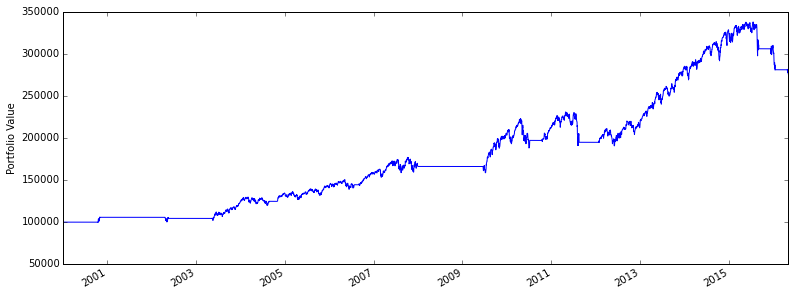

In [5]:
figsize(13,5)

perf_manual.portfolio_value.plot()

plt.ylabel("Portfolio Value")

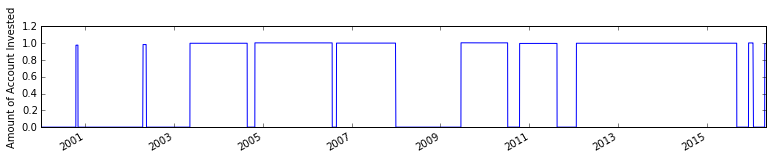

In [6]:
figsize(13,2)
# gross_leverage shows you how much of your portfolio was invested each day
# in this case it goes between 0 and 1 depending on if we were holding AAPL in our algo,
# if we were trading on margin, gross_leverage could be > 1.

perf_manual.gross_leverage.plot()

plt.ylabel("Amount of Account Invested")

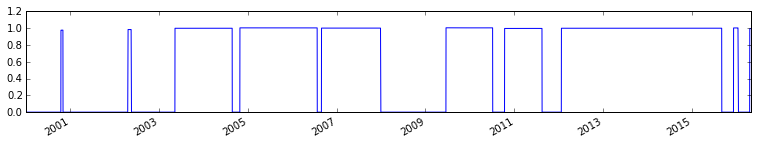

In [7]:
# net_leverage nets your long exposure with your short exposure, and reports the difference.
# in this case since we do not short with this strategy, net_leverage == gross_leverage
perf_manual.net_leverage.plot()

In [8]:
perf_manual.columns

Index([u'SPY_price', u'algo_volatility', u'algorithm_period_return', u'alpha',
       u'benchmark_period_return', u'benchmark_volatility', u'beta',
       u'capital_used', u'ending_cash', u'ending_exposure', u'ending_value',
       u'excess_return', u'gross_leverage', u'information', u'long_exposure',
       u'long_mavg', u'long_value', u'longs_count', u'max_drawdown',
       u'max_leverage', u'net_leverage', u'orders', u'period_close',
       u'period_label', u'period_open', u'pnl', u'portfolio_value',
       u'positions', u'returns', u'sharpe', u'short_exposure', u'short_mavg',
       u'short_value', u'shorts_count', u'sortino', u'starting_cash',
       u'starting_exposure', u'starting_value', u'trading_days',
       u'transactions', u'treasury_period_return'],
      dtype='object')

In [9]:
perf_manual.tail()

,SPY_price,algo_volatility,algorithm_period_return,alpha,benchmark_period_return,benchmark_volatility,beta,capital_used,ending_cash,ending_exposure,...,short_mavg,short_value,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return
2016-04-28 20:00:00,207.449997,0.110684,1.793475,0.089635,0.408959,0.200272,0.304124,0,1571.916119,277775.545983,...,202.503566,0,0,1.024871,1571.916119,280319.658034,280319.658034,4106,[],0.0184
2016-04-29 20:00:00,206.330002,0.110679,1.778478,0.088892,0.401825,0.200251,0.304156,0,1571.916119,276275.872678,...,202.808079,0,0,1.015560,1571.916119,277775.545983,277775.545983,4107,[],0.0183
2016-05-02 20:00:00,207.970001,0.110682,1.800437,0.089662,0.412774,0.200236,0.304218,0,1571.916119,278471.831339,...,203.147183,0,0,1.024734,1571.916119,276275.872678,276275.872678,4108,[],0.0188
2016-05-03 20:00:00,206.160004,0.110691,1.776202,0.088866,0.400515,0.200224,0.304303,0,1571.916119,276048.245356,...,203.394772,0,0,1.015626,1571.916119,278471.831339,278471.831339,4109,[],0.0181
2016-05-04 20:00:00,205.009995,0.110687,1.760803,0.088191,0.392201,0.200205,0.304340,0,1571.916119,274508.383305,...,203.668308,0,0,1.007159,1571.916119,276048.245356,276048.245356,4110,[],0.0179


In [10]:
perf_manual[['SPY_price', 'short_mavg', 'long_mavg']].tail()

,SPY_price,short_mavg,long_mavg
2016-04-28 20:00:00,207.449997,202.503566,199.761111
2016-04-29 20:00:00,206.330002,202.808079,199.756699
2016-05-02 20:00:00,207.970001,203.147183,199.752173
2016-05-03 20:00:00,206.160004,203.394772,199.737761
2016-05-04 20:00:00,205.009995,203.668308,199.717009
